In [1]:
!pip install TwitterSearch

  Created wheel for TwitterSearch: filename=TwitterSearch-1.0.2-cp37-none-any.whl size=18441 sha256=b44c7c240f19c86a14395aa70f9d1a958241a0b86d951e27b0d70c3102cf1099
  Stored in directory: /Users/lauradamacenodealmeida/Library/Caches/pip/wheels/4e/98/87/016442cb92cf56a0e262e7d68ad00b3701928e247d04955fdb
Successfully built TwitterSearch


In [45]:
from TwitterSearch import *
import pandas as pd
import codecs
import json
from pandas.io.json import json_normalize
import nltk
from nltk import tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
import unidecode
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lauradamacenodealmeida/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lauradamacenodealmeida/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [112]:
def generate_tweet(key,secret,token,token_secret, pesquisa_tweet, language):
    try:
        tweets = TwitterSearch(
            consumer_key = key,
            consumer_secret = secret,
            access_token = token,
            access_token_secret = token_secret
        )
        pesquisa = TwitterSearchOrder()
        pesquisa.set_keywords([pesquisa_tweet])
        pesquisa.set_language(language)
        tweetss = []

        for tweet in tweets.search_tweets_iterable(pesquisa):
            #print('@{0} tweeted: {1}'.format(tweet['user']['screen_name'], tweet['text']))
            tweetss.append(tweet)

        with open('tweets.json', 'w') as arq:
            json.dump(tweetss, arq, indent=2)
        
    except TwitterSearchException as e:
        print(e)

In [121]:
generate_tweet('xx','xx','xxx','xxx', 'Anne with an E','pt')




In [122]:
conteudo = open('tweets.json').read()
_json = json.loads(conteudo)
df = json_normalize(_json)
#df = pd.DataFrame.from_dict(df)

In [123]:
df= pd.read_json(conteudo)

In [131]:
df.shape

(94, 30)

In [125]:
tweets_filme = df.text

In [126]:
tweets_filme = tweets_filme.to_frame()

In [127]:
tweets_filme

,text
0,RT @Cordheli: Gente real que Manu e Daniel es...
1,RT @exitoinabr: Manu Gavasi e Daniel admitiram...
2,RT @eita_myy: @NetflixBrasil Já que a senhora ...
3,bom dia pra quem viu o último episódio de Anne...
4,e lá vamos nós de desenho da anne pq RENEW ANN...
...,...
89,RT @todateen: Nossa fada sensata e o labrador ...
90,RT @EduardoJorge: Netflix: RENEW ANNE WITH AN ...
91,terminei Anne with an E e agora minha vida não...
92,RT @Fanbase07136466: Quando vocês descobriram ...


In [142]:
tweets_filme.text[0]

'RT @Cordheli: Gente real que Manu e Daniel  estavam  falando de Anne with an e? HAAAAA AMOOOO.\n#BBB200 https://t.co/bqIOk585eR'

## Pré-processamento

In [132]:
token_pontuacao = tokenize.WordPunctTokenizer()

In [133]:
from string import punctuation
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

In [134]:
frase_processada = list()
def tokenize_frase(frase):
    palavras_texto = frase.lower()
    palavras_texto = token_pontuacao.tokenize(frase)
    palavra = []
    stopwords = nltk.corpus.stopwords.words('portuguese')
    for i in palavras_texto:
        if not i.isnumeric() and i.lower() not in stopwords and i not in pontuacao:
            palavra.append(i.lower())
    #     frase = nltk.word_tokenize(frase)
    frase_processada.append(' '.join(palavra))
    #return palavra

In [135]:
def removerAcentosECaracteresEspeciais(frase):
    
    frase_sem_acento = unidecode.unidecode(frase) #remove acentos
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', frase_sem_acento)
    #return frase_sem_acento

In [136]:
def preprocess(data):
    data  = removerAcentosECaracteresEspeciais(data)
    tokenize_frase(data)

    

In [137]:
tweets_filme.text.map(preprocess)
tweets_filme['tratamento_1'] = frase_processada

In [138]:
tweets_filme

,text,tratamento_1
0,RT @Cordheli: Gente real que Manu e Daniel es...,rt cordheli gente real manu daniel falando ann...
1,RT @exitoinabr: Manu Gavasi e Daniel admitiram...,rt exitoinabr manu gavasi daniel admitiram ado...
2,RT @eita_myy: @NetflixBrasil Já que a senhora ...,rt eitamyy netflixbrasil ja senhora falando ca...
3,bom dia pra quem viu o último episódio de Anne...,bom dia pra viu ultimo episodio anne with an e...
4,e lá vamos nós de desenho da anne pq RENEW ANN...,la vamos desenho anne pq renew anne with an ne...
...,...,...
89,RT @todateen: Nossa fada sensata e o labrador ...,rt todateen fada sensata labrador casa unindo ...
90,RT @EduardoJorge: Netflix: RENEW ANNE WITH AN ...,rt eduardojorge netflix renew anne with an sea...
91,terminei Anne with an E e agora minha vida não...,terminei anne with an agora vida nao faz sentido
92,RT @Fanbase07136466: Quando vocês descobriram ...,rt fanbase07136466 voces descobriram miranda p...


In [139]:
def wordcloud_tweets(texto, coluna_texto):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]]) #lista contendo todas as frases

    word_cloud = WordCloud(width=800, height=500,max_font_size=110).generate(todas_palavras)
    plt.figure(figsize=[10,10])
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title('Wordcloud dos tweets sobre a série Anne with an E')

    plt.axis("off")
    plt.show()


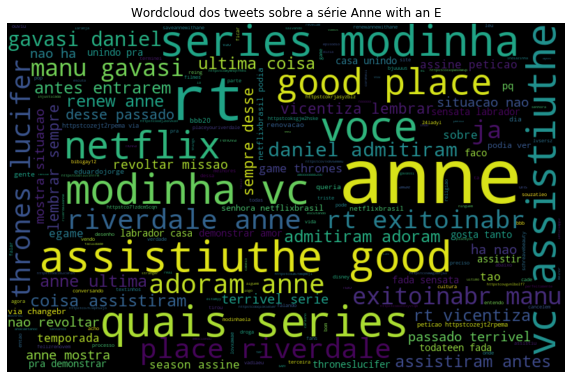

In [140]:
wordcloud_tweets(tweets_filme,'tratamento_1')

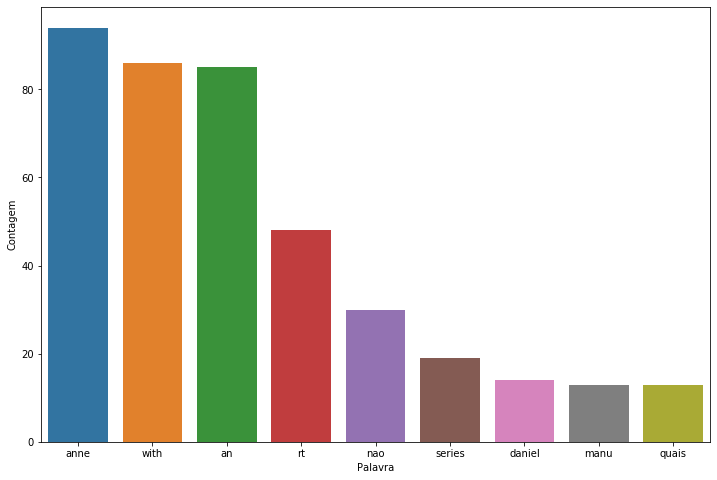

In [141]:
def pareto(texto, coluna, quantidade):    
    todas_palavras = ' '.join([text for text in texto[coluna]]) #lista contendo todas as frases
    token_espaco = tokenize.WhitespaceTokenizer()
    token = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token)
    df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()), 'Frequencia': list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns= "Frequencia", n=quantidade)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequencia")
    ax.set(ylabel="Contagem")
    plt.show()
    
pareto(tweets_filme,'tratamento_1', 9)